# Neuropixel Spiking and LFP analysis

- [Original Article](https://www.nature.com/articles/s41586-019-1787-x)
- [Neuromatch Notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/projects/neurons/load_steinmetz_decisions.ipynb#scrollTo=J4a1U2AnrDb_)

In [16]:
import numpy as np
import scipy.signal as sig
import netCDF4 as nc
import matplotlib.pyplot as plt
from pathlib import Path
import os
import scipy.stats as stats
import fooof
import scipy
import pingouin as pg
from scipy.signal import hilbert
from scipy.signal import butter, lfilter

In [14]:
# Create a function to apply a bandpass filter.
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

## Loading and selecting datas of interest:

### Load dataset:

In [2]:
# create path for sourcedata steinmetz using pathlib
source_path = Path(os.getcwd()).parent / "sourcedata"
data_path = os.path.join(source_path, "steinmetz_2016-12-14_Cori.nc")
data = nc.Dataset(data_path)

### Exploring dataset:

In [3]:
data.variables["brain_area"][:]

array(['ACA', 'MOs', 'ACA', 'LS', 'MOs', 'ACA', 'root', 'MOs', 'MOs',
       'LS', 'LS', 'LS', 'MOs', 'LS', 'LS', 'LS', 'ACA', 'MOs', 'ACA',
       'MOs', 'ACA', 'LS', 'MOs', 'MOs', 'ACA', 'MOs', 'MOs', 'MOs', 'LS',
       'MOs', 'MOs', 'ACA', 'MOs', 'MOs', 'MOs', 'LS', 'ACA', 'LS', 'MOs',
       'ACA', 'LS', 'LS', 'ACA', 'ACA', 'LS', 'LS', 'ACA', 'ACA', 'LS',
       'MOs', 'MOs', 'ACA', 'MOs', 'MOs', 'LS', 'MOs', 'MOs', 'ACA',
       'ACA', 'LS', 'MOs', 'ACA', 'LS', 'LS', 'MOs', 'MOs', 'LS', 'LS',
       'LS', 'ACA', 'MOs', 'MOs', 'LS', 'ACA', 'ACA', 'LS', 'LS', 'ACA',
       'LS', 'MOs', 'ACA', 'LS', 'ACA', 'LS', 'MOs', 'MOs', 'MOs', 'LS',
       'MOs', 'LS', 'ACA', 'ACA', 'ACA', 'MOs', 'LS', 'ACA', 'ACA', 'LS',
       'ACA', 'LS', 'MOs', 'MOs', 'MOs', 'ACA', 'LS', 'ACA', 'ACA', 'MOs',
       'root', 'MOs', 'MOs', 'MOs', 'LS', 'MOs', 'LS', 'ACA', 'ACA',
       'ACA', 'LS', 'LS', 'ACA', 'MOs', 'LS', 'MOs', 'ACA', 'ACA', 'ACA',
       'MOs', 'ACA', 'ACA', 'MOs', 'ACA', 'MOs', 'LS', 'LS

In [4]:
np.where(data.variables["brain_area"][:] == "MOs")

(array([  1,   4,   7,   8,  12,  17,  19,  22,  23,  25,  26,  27,  29,
         30,  32,  33,  34,  38,  49,  50,  52,  53,  55,  56,  60,  64,
         65,  70,  71,  79,  84,  85,  86,  88,  93, 100, 101, 102, 107,
        109, 110, 111, 113, 121, 123, 127, 130, 132, 136, 137, 138, 143,
        144, 145, 149, 156, 159, 161, 162, 163, 164, 167, 172, 175, 176,
        177, 180, 188, 190, 191, 195, 210, 214, 223, 226, 227, 229, 235,
        239, 240, 242, 246, 247, 248, 249, 255, 257, 259, 261, 268, 269,
        278, 286, 297, 298, 301, 303, 308, 318, 323, 326, 330, 333, 334,
        335, 341, 345, 348, 349, 353, 354, 358, 360], dtype=int64),)

### Selecting variable of interest:
- brain_area (str): MOs is primary motor cortex
- area_lfp (np.ndarray): array of shape (364, 250) : 364 trials of each 2.5s
- area_spiking (np.ndarray): array of shape (113, 364, 250) : 364 trials of each 2.5s, with 113 units recorded (# neurons)

In [5]:
brain_area = "MOs" # select 1 brain area, here primary motor cortex 

brain_area_lfp_idx = np.where(data.variables["brain_area"][:] == brain_area)[0][0]
area_lfp = data.variables["lfp"][brain_area_lfp_idx].data # select all lfp data from MOs
area_lfp

array([[ 9.41496599e-01, -4.18367347e-02, -8.50850340e+00, ...,
         4.52482993e+00, -1.68367347e-02,  8.23316327e+00],
       [ 8.85068027e+00,  7.84234694e+00,  7.06734694e+00, ...,
         2.85068027e+00,  1.97568027e+00,  6.57568027e+00],
       [ 1.14316327e+01, -2.35034014e-01,  4.95663265e+00, ...,
        -1.97100340e+01, -1.91850340e+01, -9.22670068e+00],
       ...,
       [-2.93656463e+00, -2.77823129e+00, -2.50323129e+00, ...,
         1.06134354e+01,  1.14551020e+01,  9.70510204e+00],
       [ 2.83673469e-01, -1.64132653e+00, -1.16326531e-01, ...,
         1.36420068e+01,  8.68367347e+00,  3.62534014e+00],
       [ 1.86253401e+01,  1.20336735e+01,  5.75034014e+00, ...,
        -6.66326531e-01, -7.89965986e+00, -1.74746599e+01]])

In [6]:
area_lfp.shape # 364 trials of 2.5s containing lfp signal from MOs

(364, 250)

In [7]:
brain_area_spiking_idx = np.where(data.variables["brain_area"][:] == brain_area)[0]
brain_area_spiking_idx
area_spiking = data.variables["spike_rate"][brain_area_spiking_idx].data # select all spiking activity data from MOs
area_spiking

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [8]:
area_spiking.shape # 364 trials of 2.5s containing spiking activity from MOs, from 113 neurons

(113, 364, 250)

## OVERVIEW POPULATION LEVEL: Phase-locked analysis across all recorded neurons, trials concatenated :

#### Select and pool datas:

In [78]:
pooled_neurons = area_spiking.sum(0)
lfp_activity_concatenate = np.hstack(area_lfp) # concatenate all 364 trials together
spiking_activity_global_concatenate = np.hstack(pooled_neurons) # concatenate all 364 trials together

#### In alpha band:

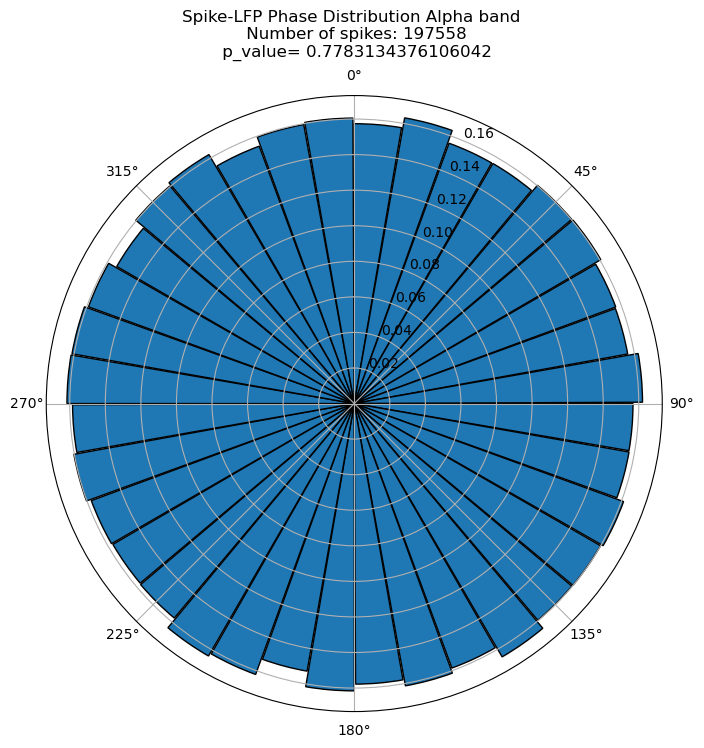

In [32]:
lowcut = 8  # Lower cutoff frequency for alpha (in Hz)
highcut = 12  # Upper cutoff frequency for alpha (in Hz)

# Apply the bandpass filter to your LFP data.
filtered_lfp = bandpass_filter(lfp_activity_concatenate, lowcut, highcut, 100)

# calculate phase of oscillations:
analytic_signal = hilbert(filtered_lfp)
phase = np.angle(analytic_signal)

spike_idx = np.where(spiking_activity_global_concatenate != 0)[0]

# Extract LFP phase values at spike times
spike_lfp_phases = phase[spike_idx]

# Create a polar histogram to visualize the spike phase distribution.
# The `bins` parameter controls the number of bins in the polar plot.

plt.figure(figsize=(8, 8))
n, bins, patches = plt.hist(spike_lfp_phases, bins=36, density=True, color='b', alpha=0.7)
plt.clf()  # Clear the histogram from the current figure

# Calculate the mean phase angle
mean_phase = np.angle(np.mean(np.exp(1j * spike_lfp_phases)))

# Perform a Rayleigh test
result = pg.circ_rayleigh(spike_lfp_phases)

# Extract the test statistic and p-value
test_statistic = result[0]
p_value = result[1]

# Create a polar plot with phase values on the x-axis and spike density (or count) on the y-axis.

ax = plt.subplot(111, projection='polar')
ax.set_theta_zero_location("N")  # Set the top of the plot as North (0 radians)
ax.set_theta_direction(-1)      # Rotate clockwise

# Normalize the bin heights so that the integral is 1 (density plot)
width = 2 * np.pi / len(bins)
bars = ax.bar(bins[:-1], n, width=width, align="edge", edgecolor='k')

plt.title(f"Spike-LFP Phase Distribution Alpha band \n Number of spikes: {sum(spiking_activity_global_concatenate)}\n p_value= {p_value}", va='bottom')
plt.show()


#### In Theta band:

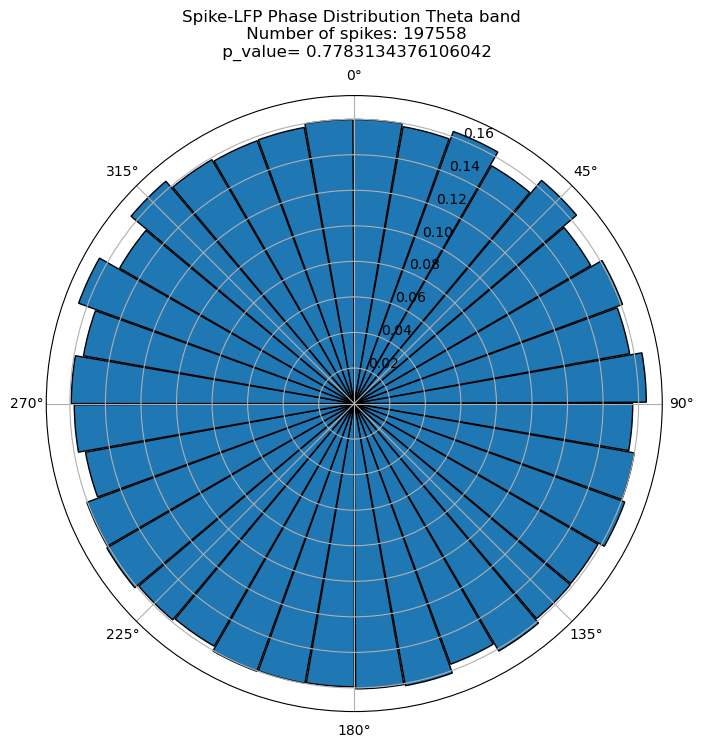

In [33]:
lowcut = 4  # Lower cutoff frequency for theta (in Hz)
highcut = 8  # Upper cutoff frequency for theta (in Hz)

# Apply the bandpass filter to your LFP data.
filtered_lfp = bandpass_filter(lfp_activity_concatenate, lowcut, highcut, 100)

# calculate phase of oscillations:
analytic_signal = hilbert(filtered_lfp)
phase = np.angle(analytic_signal)

spike_idx = np.where(spiking_activity_global_concatenate != 0)[0]

# Extract LFP phase values at spike times
spike_lfp_phases = phase[spike_idx]

# Create a polar histogram to visualize the spike phase distribution.
# The `bins` parameter controls the number of bins in the polar plot.

plt.figure(figsize=(8, 8))
n, bins, patches = plt.hist(spike_lfp_phases, bins=36, density=True, color='b', alpha=0.7)
plt.clf()  # Clear the histogram from the current figure

# Create a polar plot with phase values on the x-axis and spike density (or count) on the y-axis.

ax = plt.subplot(111, projection='polar')
ax.set_theta_zero_location("N")  # Set the top of the plot as North (0 radians)
ax.set_theta_direction(-1)      # Rotate clockwise

# Normalize the bin heights so that the integral is 1 (density plot)
width = 2 * np.pi / len(bins)
bars = ax.bar(bins[:-1], n, width=width, align="edge", edgecolor='k')

plt.title(f"Spike-LFP Phase Distribution Theta band \n Number of spikes: {sum(spiking_activity_global_concatenate)}\n p_value= {p_value}", va='bottom')
plt.show()


# Trial level: phase-locking spike analysis of all neurons in each trial:

#### Phase-locking in alpha band :

Significant phase locking detected.


<Figure size 640x480 with 0 Axes>

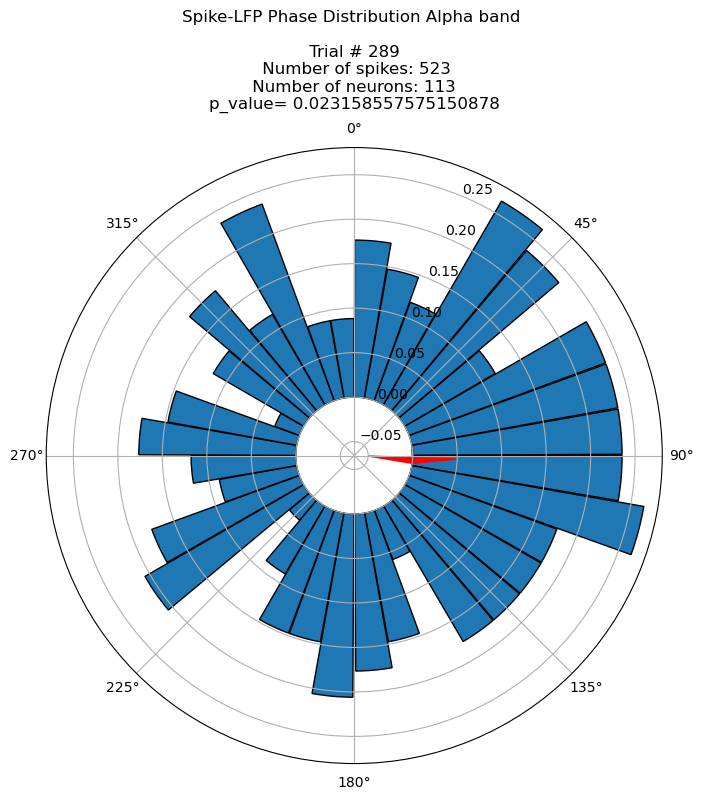

significant phase-locking with alpha in trials #: [289]


In [77]:
significant_trials_alpha = []

for i in range(0, area_spiking.shape[1], 1):
#for i in range(300, 330, 1):
    lfp_activity_trial_i = area_lfp[i]
    spiking_activity_trial_i = area_spiking[:, i, :].sum(0)

    # Define the frequency range for alpha activity.
    lowcut = 8  # Lower cutoff frequency for alpha (in Hz)
    highcut = 12  # Upper cutoff frequency for alpha (in Hz)

    # Apply the bandpass filter to your LFP data.
    filtered_lfp = bandpass_filter(lfp_activity_trial_i, lowcut, highcut, 100)

    analytic_signal = hilbert(filtered_lfp)
    phase = np.angle(analytic_signal)

    spike_idx = np.where(spiking_activity_trial_i != 0)[0]

    # Extract LFP phase values at spike times
    spike_lfp_phases = phase[spike_idx]

    # Calculate the mean phase angle
    mean_phase = np.angle(np.mean(np.exp(1j * spike_lfp_phases)))

    # Perform a Rayleigh test
    result = pg.circ_rayleigh(spike_lfp_phases)

    # Extract the test statistic and p-value
    test_statistic = result[0]
    p_value = result[1]

    if p_value < 0.05:
        print("Significant phase locking detected.")
        significant_trials_alpha.append(i)
        plt.figure()
        # Create a polar histogram to visualize the spike phase distribution.
        # The `bins` parameter controls the number of bins in the polar plot.

        plt.figure(figsize=(8, 8))
        n, bins, patches = plt.hist(spike_lfp_phases, bins=36, density=True, color='b', alpha=0.7)
        plt.clf()  # Clear the histogram from the current figure

        # Create a polar plot with phase values on the x-axis and spike density (or count) on the y-axis.

        ax = plt.subplot(111, projection='polar')
        ax.set_theta_zero_location("N")  # Set the top of the plot as North (0 radians)
        ax.set_theta_direction(-1)      # Rotate clockwise

        # Normalize the bin heights so that the integral is 1 (density plot)
        width = 2 * np.pi / len(bins)
        bars = ax.bar(bins[:-1], n, width=width, align="edge", edgecolor='k')

        # Normalize the arrow length based on the mean phase
        arrow_length = np.abs(np.mean(np.exp(1j * spike_lfp_phases)))

        # Add the arrow
        ax.arrow(mean_phase, 0, arrow_length, 0, head_width=0.1, head_length=0.1, fc='red', ec='red')

        plt.title(f"Spike-LFP Phase Distribution Alpha band \n\n Trial # {i} \n Number of spikes: {sum(spiking_activity_trial_i)}\n Number of neurons: {area_spiking.shape[0]} \np_value= {p_value}", va='bottom')
        plt.show()

print(f"significant phase-locking with alpha in trials #: {significant_trials_alpha}")

#### Phase-locking in theta band :

Significant phase locking detected.


<Figure size 640x480 with 0 Axes>

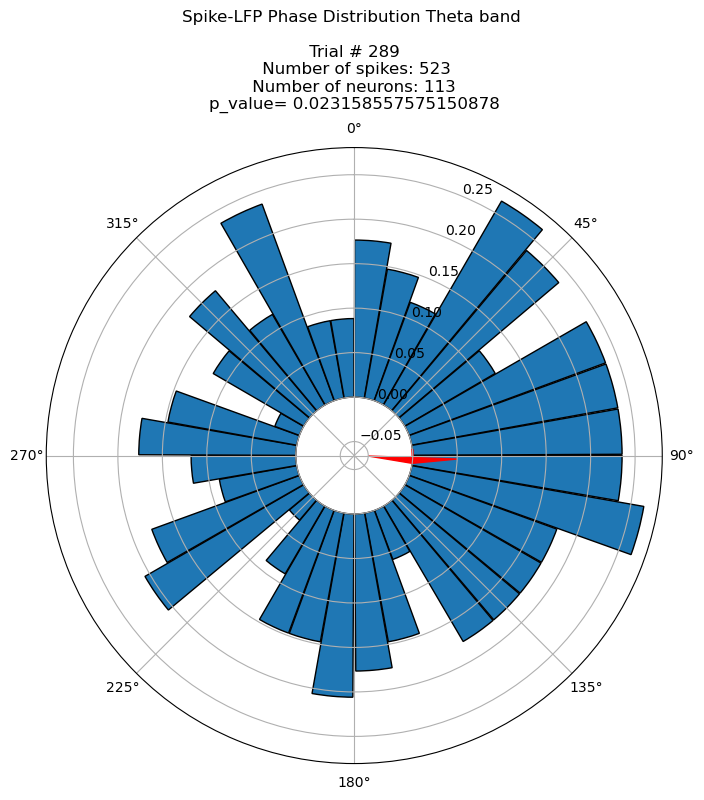

significant phase-locking with Theta in trials #: [289]


In [76]:
significant_trials_theta = []

for i in range(0, area_spiking.shape[1], 1):
#for i in range(300, 330, 1):
    lfp_activity_trial_i = area_lfp[i]
    spiking_activity_trial_i = area_spiking[:, i, :].sum(0)
    
    lowcut = 8  # Lower cutoff frequency for theta (in Hz)
    highcut = 12  # Upper cutoff frequency for theta (in Hz)

    # Apply the bandpass filter to your LFP data.
    filtered_lfp = bandpass_filter(lfp_activity_trial_i, lowcut, highcut, 100)

    analytic_signal = hilbert(filtered_lfp)
    phase = np.angle(analytic_signal)

    spike_idx = np.where(spiking_activity_trial_i != 0)[0]

    # Extract LFP phase values at spike times
    spike_lfp_phases = phase[spike_idx]

    # Calculate the mean phase angle
    mean_phase = np.angle(np.mean(np.exp(1j * spike_lfp_phases)))

    # Perform a Rayleigh test
    result = pg.circ_rayleigh(spike_lfp_phases)

    # Extract the test statistic and p-value
    test_statistic = result[0]
    p_value = result[1]

    if p_value < 0.05:
        print("Significant phase locking detected.")
        significant_trials_theta.append(i)

        plt.figure()

        # Create a polar histogram to visualize the spike phase distribution.
        # The `bins` parameter controls the number of bins in the polar plot.

        plt.figure(figsize=(8, 8))
        n, bins, patches = plt.hist(spike_lfp_phases, bins=36, density=True, color='b', alpha=0.7)
        plt.clf()  # Clear the histogram from the current figure

        # Create a polar plot with phase values on the x-axis and spike density (or count) on the y-axis.

        ax = plt.subplot(111, projection='polar')
        ax.set_theta_zero_location("N")  # Set the top of the plot as North (0 radians)
        ax.set_theta_direction(-1)      # Rotate clockwise

        # Normalize the bin heights so that the integral is 1 (density plot)
        width = 2 * np.pi / len(bins)
        bars = ax.bar(bins[:-1], n, width=width, align="edge", edgecolor='k')

        # Normalize the arrow length based on the mean phase
        arrow_length = np.abs(np.mean(np.exp(1j * spike_lfp_phases)))

        # Add the arrow
        ax.arrow(mean_phase, 0, arrow_length, 0, head_width=0.1, head_length=0.1, fc='red', ec='red')

        plt.title(f"Spike-LFP Phase Distribution Theta band \n\n Trial # {i} \n Number of spikes: {sum(spiking_activity_trial_i)}\n Number of neurons: {area_spiking.shape[0]} \np_value= {p_value}", va='bottom')
        plt.show()

print(f"significant phase-locking with Theta in trials #: {significant_trials_theta}")

# Cell level: phase-locking spike analysis of each neuron in all trials concatenated:

#### Phase-locking in theta band

<Figure size 640x480 with 0 Axes>

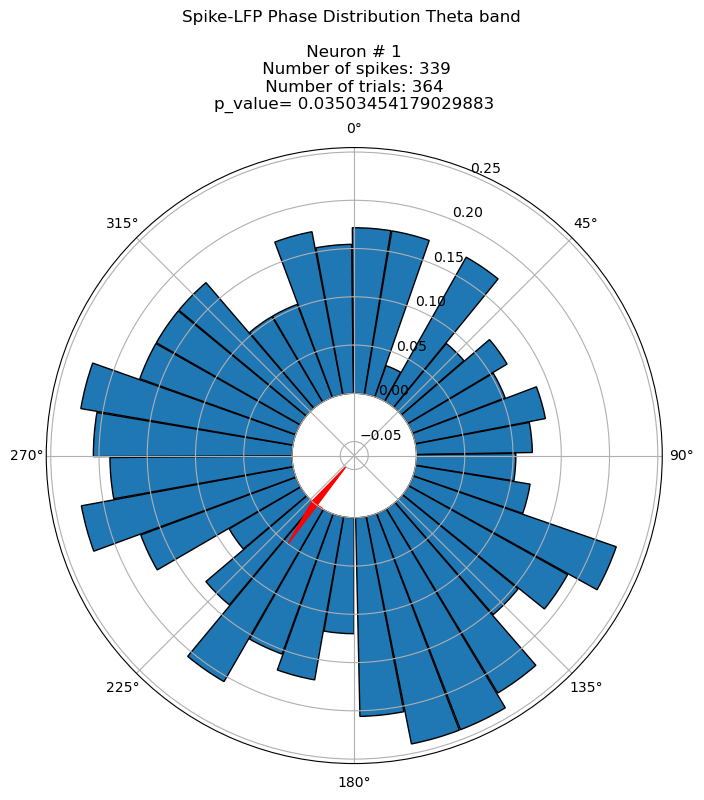

<Figure size 640x480 with 0 Axes>

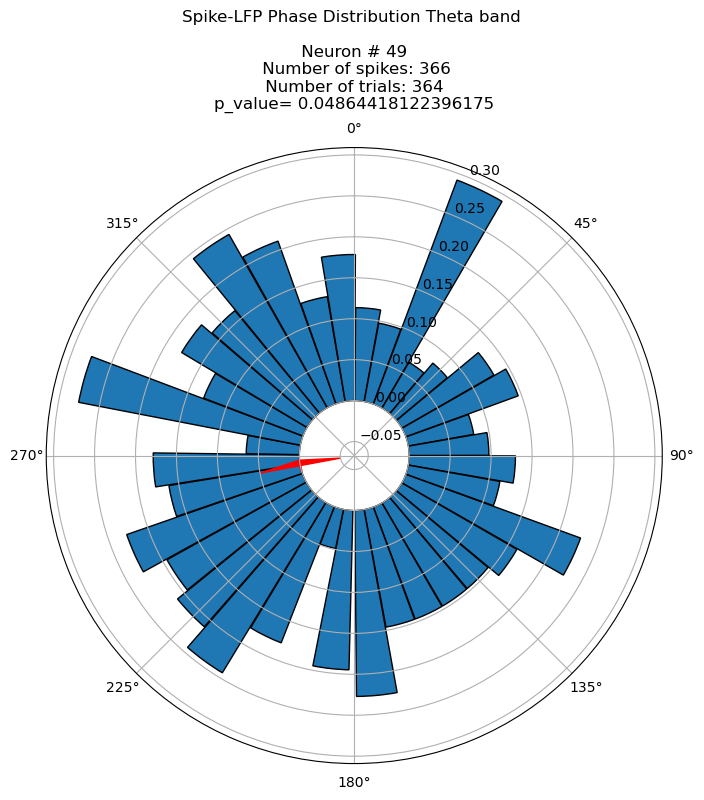

<Figure size 640x480 with 0 Axes>

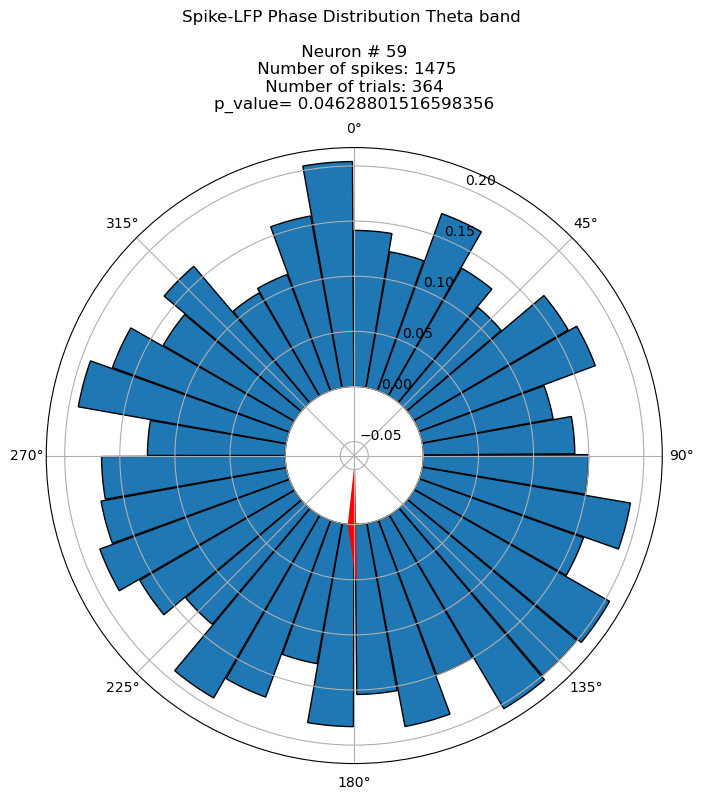

<Figure size 640x480 with 0 Axes>

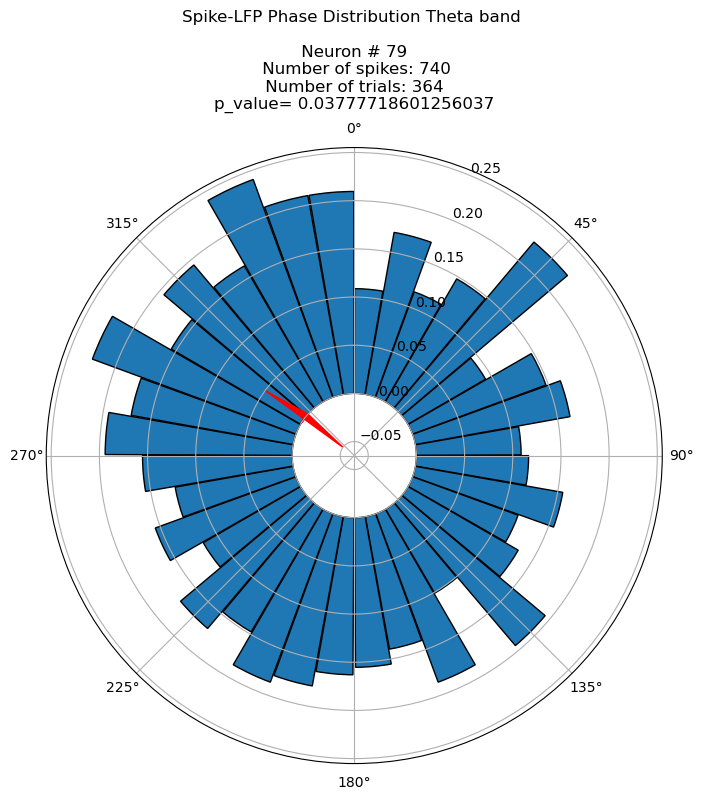

<Figure size 640x480 with 0 Axes>

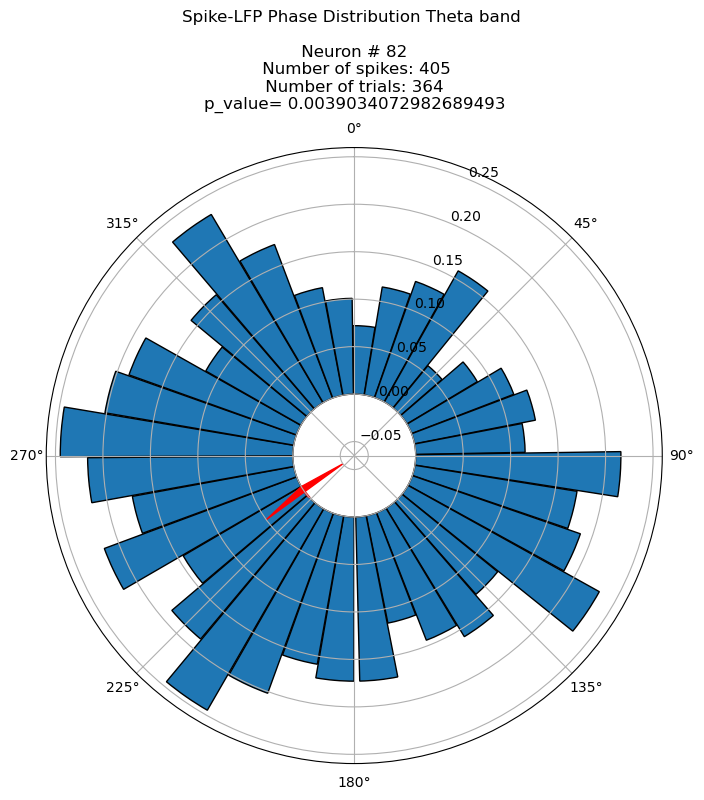

<Figure size 640x480 with 0 Axes>

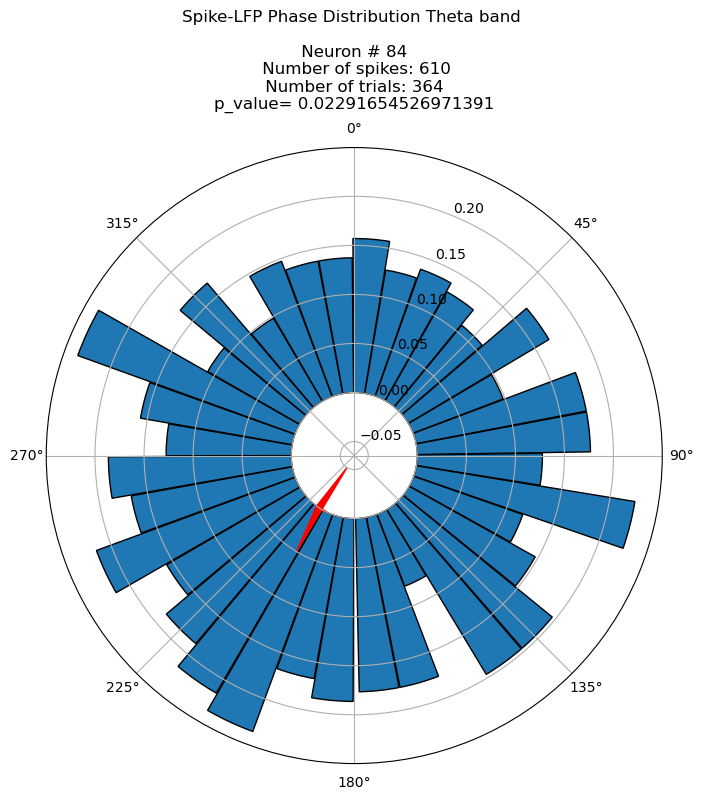

<Figure size 640x480 with 0 Axes>

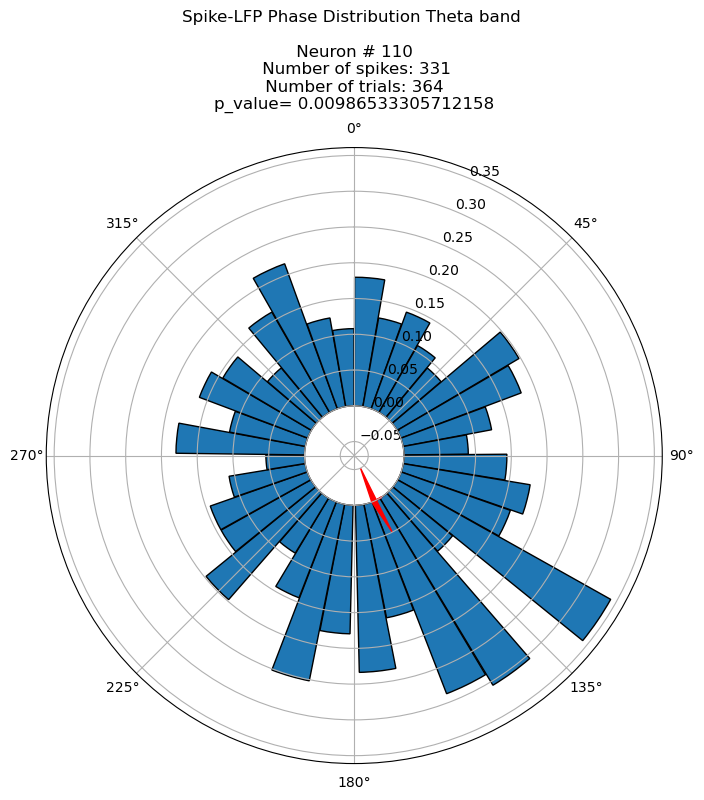

significant phase-locking with Theta in neurons #: [1, 49, 59, 79, 82, 84, 110]


In [70]:
significantly_phase_locked_neurons = []

# Extract the spiking activity of a specific neuron for a specific trial
for i in range(0, area_spiking.shape[0], 1):
    neuron_idx_i = i  # Index of the neuron you want to extract (0 to 112)
    spiking_activity_neuron_i = area_spiking[i]

# 'spiking_activity' now contains the spiking activity of the specified neuron for the specified trial.
    lfp_activity_concatenate = np.hstack(area_lfp)
    spiking_activity_neuron_i_concatenate = np.hstack(spiking_activity_neuron_i)

    lowcut = 4  # Lower cutoff frequency for theta (in Hz)
    highcut = 8  # Upper cutoff frequency for tetha (in Hz)

    # Apply the bandpass filter to your LFP data.
    filtered_lfp = bandpass_filter(lfp_activity_concatenate, lowcut, highcut, 100)

    # 'filtered_lfp' now contains the LFP data filtered in the gamma frequency range (30-100 Hz).

    analytic_signal = hilbert(filtered_lfp)
    phase = np.angle(analytic_signal)

    spike_idx = np.where(spiking_activity_neuron_i_concatenate != 0)[0]

    # Assuming you have an array 'lfp_phases' containing LFP phase values at all time points,
    # and an array 'spike_indices' containing the indices of spike times.

    # Extract LFP phase values at spike times
    spike_lfp_phases = phase[spike_idx]

    # Calculate the mean phase angle
    mean_phase = np.angle(np.mean(np.exp(1j * spike_lfp_phases)))

    # Perform a Rayleigh test
    result = pg.circ_rayleigh(spike_lfp_phases)

    # Extract the test statistic and p-value
    test_statistic = result[0]
    p_value = result[1]

    if p_value < 0.05:
        significantly_phase_locked_neurons.append(i)
        plt.figure()
        # Create a polar histogram to visualize the spike phase distribution.
        # The `bins` parameter controls the number of bins in the polar plot.

        plt.figure(figsize=(8, 8))
        n, bins, patches = plt.hist(spike_lfp_phases, bins=36, density=True, color='b', alpha=0.7)
        plt.clf()  # Clear the histogram from the current figure

        # Create a polar plot with phase values on the x-axis and spike density (or count) on the y-axis.

        ax = plt.subplot(111, projection='polar')
        ax.set_theta_zero_location("N")  # Set the top of the plot as North (0 radians)
        ax.set_theta_direction(-1)      # Rotate clockwise

        # Normalize the bin heights so that the integral is 1 (density plot)
        width = 2 * np.pi / len(bins)
        bars = ax.bar(bins[:-1], n, width=width, align="edge", edgecolor='k')

        # Normalize the arrow length based on the mean phase
        arrow_length = np.abs(np.mean(np.exp(1j * spike_lfp_phases)))

        # Add the arrow
        ax.arrow(mean_phase, 0, arrow_length, 0, head_width=0.1, head_length=0.1, fc='red', ec='red')

        plt.title(f"Spike-LFP Phase Distribution Theta band \n\n Neuron # {i} \n Number of spikes: {sum(spiking_activity_neuron_i_concatenate)}\n Number of trials: {area_spiking.shape[1]} \np_value= {p_value}", va='bottom')
        plt.show()

print(f"significant phase-locking with Theta in neurons #: {significantly_phase_locked_neurons}")


#### Phase-locking in alpha band :

<Figure size 640x480 with 0 Axes>

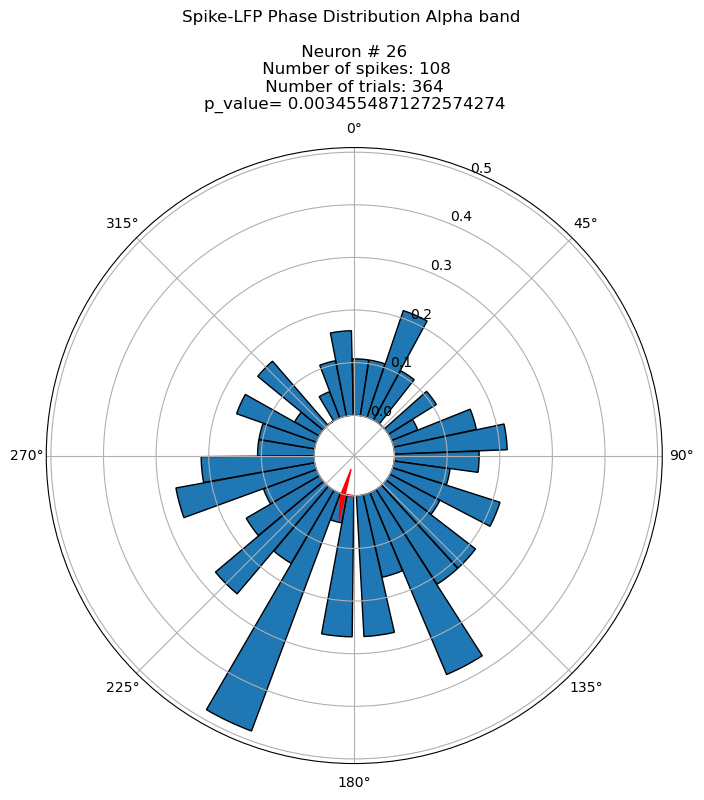

<Figure size 640x480 with 0 Axes>

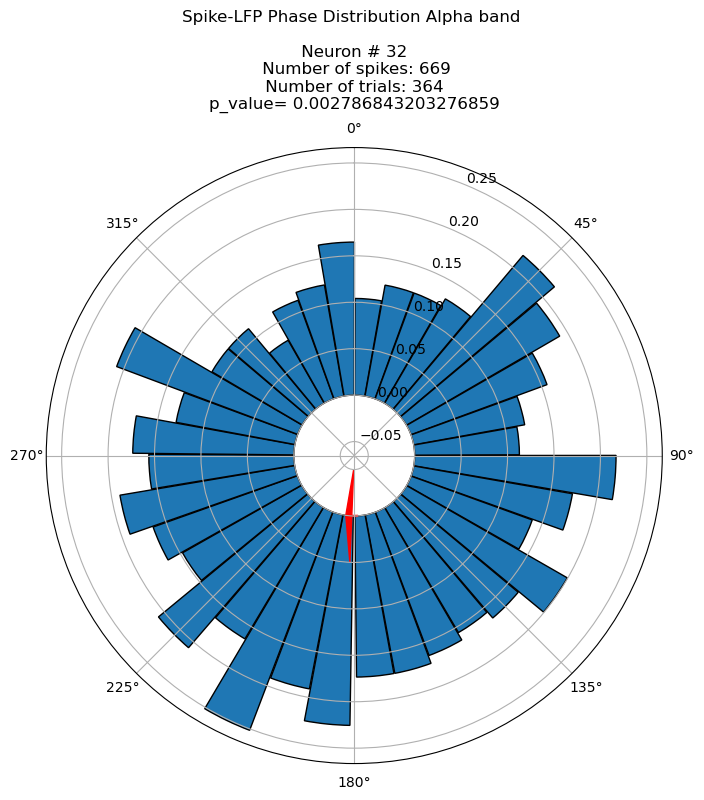

significant phase-locking with Alpha in neurons #: [26, 32]


In [71]:
significantly_phase_locked_neurons_alpha = []

# Extract the spiking activity of a specific neuron for a specific trial
for i in range(0, area_spiking.shape[0], 1):
    neuron_idx_i = i  # Index of the neuron you want to extract (0 to 112)
    spiking_activity_neuron_i = area_spiking[i]

# 'spiking_activity' now contains the spiking activity of the specified neuron for the specified trial.
    lfp_activity_concatenate = np.hstack(area_lfp)
    spiking_activity_neuron_i_concatenate = np.hstack(spiking_activity_neuron_i)

    lowcut = 8  # Lower cutoff frequency for alpha (in Hz)
    highcut = 12  # Upper cutoff frequency for alpha (in Hz)

    # Apply the bandpass filter to your LFP data.
    filtered_lfp = bandpass_filter(lfp_activity_concatenate, lowcut, highcut, 100)

    # 'filtered_lfp' now contains the LFP data filtered in the gamma frequency range (30-100 Hz).

    analytic_signal = hilbert(filtered_lfp)
    phase = np.angle(analytic_signal)

    spike_idx = np.where(spiking_activity_neuron_i_concatenate != 0)[0]

    # Assuming you have an array 'lfp_phases' containing LFP phase values at all time points,
    # and an array 'spike_indices' containing the indices of spike times.

    # Extract LFP phase values at spike times
    spike_lfp_phases = phase[spike_idx]

    # Calculate the mean phase angle
    mean_phase = np.angle(np.mean(np.exp(1j * spike_lfp_phases)))

    # Perform a Rayleigh test
    result = pg.circ_rayleigh(spike_lfp_phases)

    # Extract the test statistic and p-value
    test_statistic = result[0]
    p_value = result[1]

    if p_value < 0.05:
        significantly_phase_locked_neurons_alpha.append(i)
        plt.figure()
        # Create a polar histogram to visualize the spike phase distribution.
        # The `bins` parameter controls the number of bins in the polar plot.

        plt.figure(figsize=(8, 8))
        n, bins, patches = plt.hist(spike_lfp_phases, bins=36, density=True, color='b', alpha=0.7)
        plt.clf()  # Clear the histogram from the current figure

        # Create a polar plot with phase values on the x-axis and spike density (or count) on the y-axis.

        ax = plt.subplot(111, projection='polar')
        ax.set_theta_zero_location("N")  # Set the top of the plot as North (0 radians)
        ax.set_theta_direction(-1)      # Rotate clockwise

        # Normalize the bin heights so that the integral is 1 (density plot)
        width = 2 * np.pi / len(bins)
        bars = ax.bar(bins[:-1], n, width=width, align="edge", edgecolor='k')

        # Normalize the arrow length based on the mean phase
        arrow_length = np.abs(np.mean(np.exp(1j * spike_lfp_phases)))

        # Add the arrow
        ax.arrow(mean_phase, 0, arrow_length, 0, head_width=0.1, head_length=0.1, fc='red', ec='red')

        plt.title(f"Spike-LFP Phase Distribution Alpha band \n\n Neuron # {i} \n Number of spikes: {sum(spiking_activity_neuron_i_concatenate)}\n Number of trials: {area_spiking.shape[1]} \np_value= {p_value}", va='bottom')
        plt.show()

print(f"significant phase-locking with Alpha in neurons #: {significantly_phase_locked_neurons_alpha}")
